# Car Acceptability Prediction - SVC with Hyperparameter Tuning
Neil John Catapang

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

## Loading the Dataset + EDA

### Car Evaluation Dataset

The given dataset is comma-separated data file without headers. We load this dataset using pandas with <code>header=None</code>.

In [2]:
car = pd.read_csv("car.data", header=None)

# Rename the columns (dataset does not include feature names)
car.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]

display(car)
print("Dataset information:")
print(car.info(), "\n")
print(f"Dataset Summary: \n{car.describe(include="all")}")

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB
None 

Dataset Summary: 
       buying  maint doors persons lug_boot safety  class
count    1728   1728  1728    1728     1728   1728   1728
unique      4      4     4       3        3      3      4
top     vhigh  vhigh     2       2    small    low  unacc
freq      432    432   432     576      576    576   1210


All features are Dtype = object, which suggests that all features are categorical in nature. There are 1728 examples for this dataset, and the target label <code>'class'</code> have 4 unique values. Thus, prediction of car acceptability in this case is a multi-class classification problem.

### Count Plots of Features and Target

I used count plots to check the distribution of values of each feature, as well as the target class.

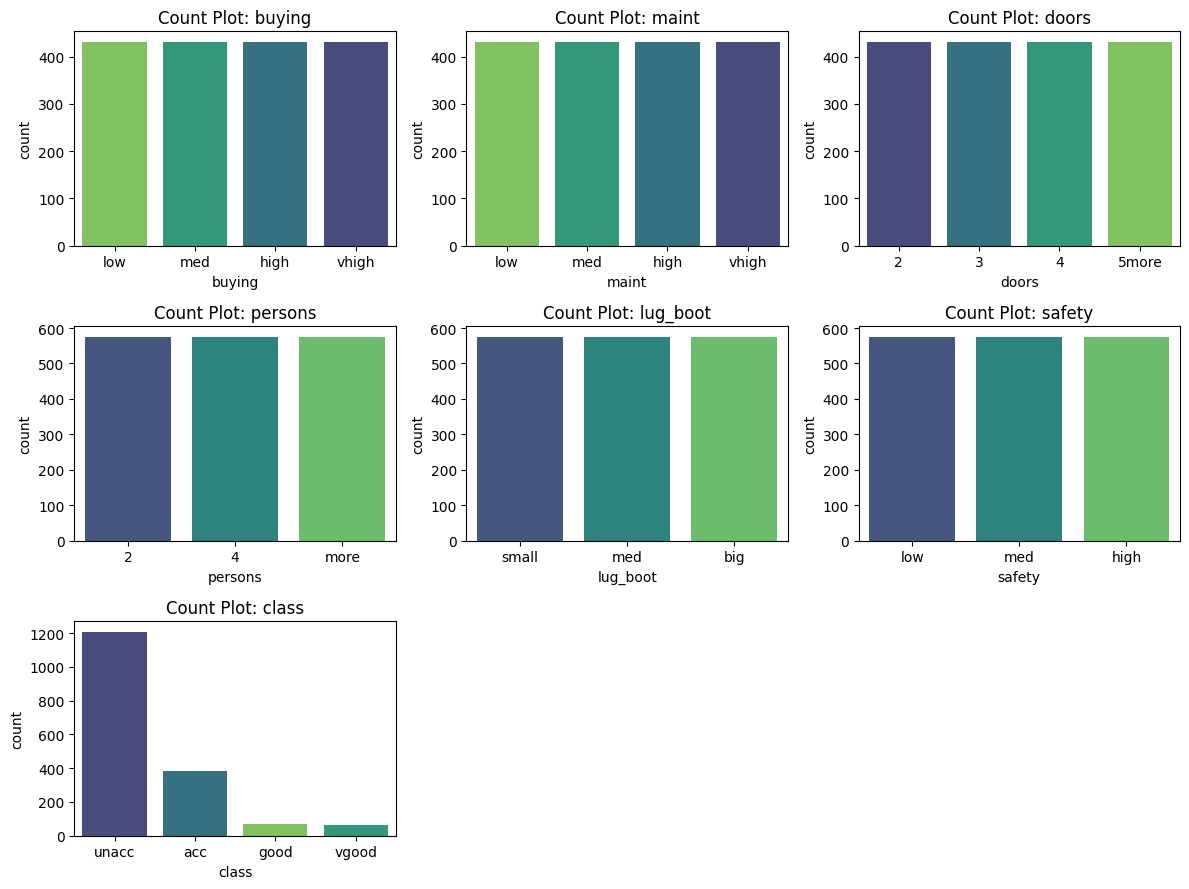

In [3]:
plt.figure(figsize=(12, 9))

for i, col in enumerate(car.columns): 
    plt.subplot(3, 3, i + 1)

    if i in [0, 1]:
        sns.countplot(x=car[col], order=['low', 'med', 'high', 'vhigh'], hue=car[col], palette='viridis')
    elif i == 4:
        sns.countplot(x=car[col], order=['small', 'med', 'big'], hue=car[col], palette='viridis')
    elif i == 5:
        sns.countplot(x=car[col], order=['low', 'med', 'high'], hue=car[col], palette='viridis')
    elif i == 6:
        sns.countplot(x=car[col], order=['unacc', 'acc', 'good', 'vgood'], hue=car[col], palette='viridis')
    else:
        sns.countplot(x=car[col], hue=car[col], palette='viridis')

    plt.title(f"Count Plot: {col}")
plt.tight_layout()
plt.show()

We can see from above that for all the features, their values are occurring with the same frequencies. However, the class imbalance is very apparent in the last subplot. This might affect the performance of the SVC model, as it will favor the majority class more than the minority classes.

In the succeeding parts of this assignment, I will try to create a model without balancing the classes to see if the SVC model can handle this type of dataset well. If not, I will proceed to balance the classes using Synthetic Minority Oversampling Technique (SMOTE).

### Heatmap of Features (Including Target)

The heatmap shows correlation between each pair of features. In this case, I also included the target in the heatmap to see if there is a linear relationship between the features and the target. This will give us an idea about the appropriate kernel to use for the SVC.

We need to transform first the features into numerical ones using <code>OrdinalEncoder</code> for ordinal features and <code>OneHotEncoder</code> for other categorical features. The labels were manually mapped (with ordinal sense) to see if there is correlation between features and target.

In [4]:
from sklearn.compose import ColumnTransformer

class_mapping = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}

X = car.drop(columns=['class'])
y = car['class']
y_encoded = car['class'].map(class_mapping)

ordinal_features = ['buying', 'maint', 'lug_boot', 'safety']
one_hot_features = ['doors', 'persons']

ordinal_categories = [
    ['low', 'med', 'high', 'vhigh'],
    ['low', 'med', 'high', 'vhigh'],
    ['small', 'med', 'big'],
    ['low', 'med', 'high']
]

feature_encoder = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
        ('ohe', OneHotEncoder(), one_hot_features)
    ]
)

X_encoded = feature_encoder.fit_transform(X)

# Access the column names again after transforming
ohe_column_names = feature_encoder.named_transformers_['ohe'].get_feature_names_out(one_hot_features).tolist()
all_feature_names = ordinal_features + ohe_column_names

# Re-convert encoded X to dataframe
X_encoded_df = pd.DataFrame(X_encoded, columns=all_feature_names)

display(X_encoded_df)

,buying,maint,lug_boot,safety,doors_2,doors_3,doors_4,doors_5more,persons_2,persons_4,persons_more
0,3.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1723,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1724,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1725,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1726,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


      buying  maint  lug_boot  safety  doors_2  doors_3  doors_4  doors_5more  \
0        3.0    3.0       0.0     0.0      1.0      0.0      0.0          0.0   
1        3.0    3.0       0.0     1.0      1.0      0.0      0.0          0.0   
2        3.0    3.0       0.0     2.0      1.0      0.0      0.0          0.0   
3        3.0    3.0       1.0     0.0      1.0      0.0      0.0          0.0   
4        3.0    3.0       1.0     1.0      1.0      0.0      0.0          0.0   
...      ...    ...       ...     ...      ...      ...      ...          ...   
1723     0.0    0.0       1.0     1.0      0.0      0.0      0.0          1.0   
1724     0.0    0.0       1.0     2.0      0.0      0.0      0.0          1.0   
1725     0.0    0.0       2.0     0.0      0.0      0.0      0.0          1.0   
1726     0.0    0.0       2.0     1.0      0.0      0.0      0.0          1.0   
1727     0.0    0.0       2.0     2.0      0.0      0.0      0.0          1.0   

      persons_2  persons_4 

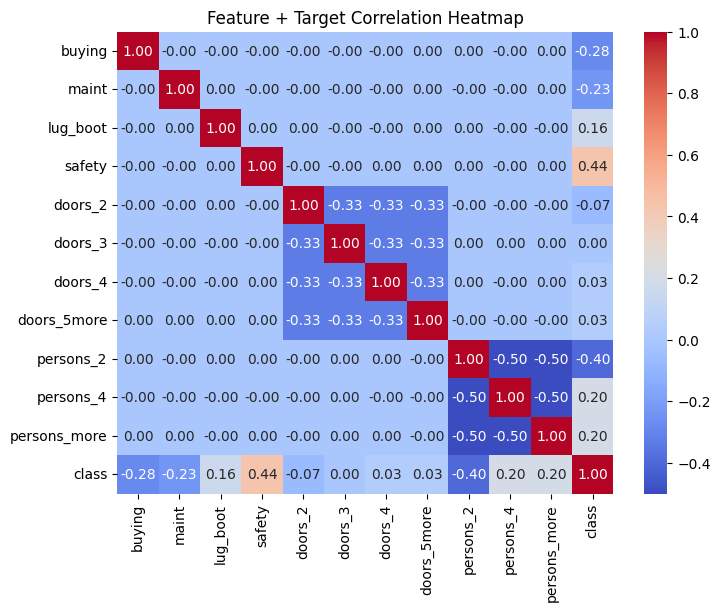

In [5]:
car_encoded = pd.concat([X_encoded_df, y_encoded], axis=1)
print(car_encoded)

corr_matrix = car_encoded.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature + Target Correlation Heatmap")
plt.show()

Features show very weak correlation with each other. The only features which have weak pairwise correlation are those who are one-hot encoded. This suggests that features in this dataset can be considered as non-correlated or independent from each other.

All features show weak correlation with the target class, which suggests that linear models may perform poorly on classification of car acceptability from the given set of features. The feature <code>safety</code> exhibits the highest correlation with the target class, making it likely one of the most important features in the dataset.

## Data Pre-processing

### Train-test Split

I used a stratified train-test split to preserve the class distribution ratio of the original dataset.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.15, random_state=0, stratify=y_encoded)
print(f'SVC - Car Acceptability Prediction')
print(X_train.shape)
print(X_test.shape)

SVC - Car Acceptability Prediction
(1468, 11)
(260, 11)


To check the class distribution, we use <code>Counter</code> to count the frequencies of each target class value.

In [7]:
from collections import Counter

y_train_count = Counter(y_train)
y_test_count = Counter(y_test)

y_train_ratio = Counter({key: round(value*100 / y_train.shape[0], 2) for key, value in y_train_count.items()})
y_test_ratio = Counter({key: round(value*100/ y_test.shape[0], 2) for key, value in y_test_count.items()})

print(f'Train dataset class distribution ratio: \n{y_train_ratio}')
print(f'Test dataset class distribution ratio: \n{y_test_ratio}')

Train dataset class distribution ratio: 
Counter({0: 70.03, 1: 22.21, 2: 4.02, 3: 3.75})
Test dataset class distribution ratio: 
Counter({0: 70.0, 1: 22.31, 2: 3.85, 3: 3.85})


We can see from above that the class distribution ratios for each split were similar to each other.

## SVC Model with Hyperparameter Tuning

### GridSearchCV + StratifiedKFold

We can now attempt to create a SVC model tuned with GridSearchCV. I used a stratified k-fold cross-validation to preserve the distribution of the classes during training and validation. I decided not to apply <code>StandardScaler</code> since all features are categorical, and they do not differ significantly in scale after encoding.

In [8]:
# The base support vector classifier pipeline
base_svm = make_pipeline(StandardScaler(), SVC())

# Specify grid of hyperparameters
param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100, 1000],
    "svc__kernel": ["linear", "rbf", 'poly', 'sigmoid'],
    "svc__gamma": ["scale", "auto"],
    "svc__degree": [2, 3, 4]
}

kfoldcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(base_svm, param_grid, scoring='accuracy', cv=kfoldcv, verbose=3, n_jobs=-1)

start = time()
grid.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid.cv_results_["params"])))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
GridSearchCV took 73.23 seconds for 144 candidate parameter settings.


In [9]:
best_model_1 = grid.best_estimator_
print("Best Parameters:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)

Best Parameters: {'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best Accuracy: 0.9754753778644563


We have created a SVC model with cross-validation accuracy score of 0.9830 using the best hyperparameters found using GridSearch as shown above.

We now try to create another model tuned via <code>RandomizedSearchCV</code>.

### RandomizedSearchCV + StratifiedKFold

Randomized Search allows for more efficient hyperparameter search without explicitly defining the grid of parameters. It can use random variable distributions to search for best hyperparameter values.

In [10]:
import scipy.stats as stats
max_iter = 20

base_svm_2 = make_pipeline(StandardScaler(), SVC())

param_dist = {
    'svc__C': stats.expon(scale=100),
    'svc__gamma': stats.expon(scale=0.1),
    'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'svc__degree': [2, 3, 4]
}

random_search = RandomizedSearchCV(
    base_svm_2,
    param_distributions=param_dist,
    n_iter=max_iter,
    verbose=2,
    n_jobs=-1,
    cv=kfoldcv,
    random_state=0,
    scoring='accuracy'
)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(random_search.cv_results_["params"])))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomizedSearchCV took 0.54 seconds for 20 candidate parameter settings.


In [11]:
best_model_2 = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

Best Parameters: {'svc__C': 97.68640611376004, 'svc__degree': 3, 'svc__gamma': 0.11231683015351368, 'svc__kernel': 'rbf'}
Best Accuracy: 0.9720693738246151


The obtained accuracy using RandomizedSearchCV is similar to the model tuned via GridSearchCV (0.9877). However, randomized search only took half a second to finish.

## Evaluation of SVC Models for Car Acceptability Prediction

### SVC Tuned via GridSearchCV

In [12]:
# SVC-GridSearch - Accuracy and Confusion Matrix
print(f"Accuracy = {best_model_1.score(X_test, y_test)}")
print('Confusion Matrix')
y_test_pred1 = best_model_1.predict(X_test)
print(confusion_matrix(y_test, y_test_pred1))

# SVC-GridSearch - Classification Report
print(classification_report(y_test, y_test_pred1, target_names=['Unacceptable', 'Acceptable', 'Good', 'Very Good']))

Accuracy = 0.9961538461538462
Confusion Matrix
[[182   0   0   0]
 [  1  57   0   0]
 [  0   0  10   0]
 [  0   0   0  10]]
              precision    recall  f1-score   support

Unacceptable       0.99      1.00      1.00       182
  Acceptable       1.00      0.98      0.99        58
        Good       1.00      1.00      1.00        10
   Very Good       1.00      1.00      1.00        10

    accuracy                           1.00       260
   macro avg       1.00      1.00      1.00       260
weighted avg       1.00      1.00      1.00       260



The model performed excellently, with accuracy, precision (weighted), and recall (weighted) score of 100%. Although the results are suspiciously high, it was ensured that appropriate data splits and no data leakage were committed in this code. These results show that the SVC model tuned via GridSearchCV is adequate for prediction.

### SVC Tuned via RandomizedSearchCV

In [13]:
# SVC-RandomizedSearch - Accuracy and Confusion Matrix
print(f"Accuracy = {best_model_2.score(X_test, y_test)}")
print('Confusion Matrix')
y_test_pred2 = best_model_2.predict(X_test)
print(confusion_matrix(y_test, y_test_pred2))

# SVC-RandomizedSearch - Classification Report
print(classification_report(y_test, y_test_pred2, target_names=['Unacceptable', 'Acceptable', 'Good', 'Very Good']))

Accuracy = 0.9961538461538462
Confusion Matrix
[[182   0   0   0]
 [  1  57   0   0]
 [  0   0  10   0]
 [  0   0   0  10]]
              precision    recall  f1-score   support

Unacceptable       0.99      1.00      1.00       182
  Acceptable       1.00      0.98      0.99        58
        Good       1.00      1.00      1.00        10
   Very Good       1.00      1.00      1.00        10

    accuracy                           1.00       260
   macro avg       1.00      1.00      1.00       260
weighted avg       1.00      1.00      1.00       260



This model performed similarly than the SVC model tuned via GridSearchCV, but with one misclassification. The accuracy, precision (weighted), and recall (weighted) scores of 100% (rounded), show that this model also can be used for car acceptability prediction.

Both models performed excellently even without balancing the target classes. This suggests that data balancing may not be required for this dataset.